In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy

In [2]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.neural_network import MLPRegressor
from sklearn.tree import ExtraTreeRegressor


import xgboost as xgb
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from data_utils import *


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_validate


In [3]:
df = pd.read_csv("data/f_train.csv")
X = df.drop(["cent_price_cor", "cent_trans_cor"],axis=1).values

inputs = ["cent_price_cor", "cent_trans_cor"] # Use this for multi-output models
inputs = ["cent_price_cor"]  # Use this for single output models 
y = df[inputs].values 


In [4]:
def plot_pred_ensemble(model, X):
    preds = pd.DataFrame()
    for name, pred in model.named_estimators_.items():
        preds[name] = pred.predict(X)
    preds["ensemble"] = model.predict(X)
    preds.sort_values(by=["ensemble"], inplace=True)
    preds = preds.apply(np.square)
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.subplot(1,2,1)
    for i in preds.columns:
        sns.lineplot(data=preds, x=np.arange(len(X)), y=i, label=i)
    plt.legend()
    plt.subplot(1,2,2)
    sns.histplot(data=preds, x="ensemble", bins=10)
    plt.show()
    

In [5]:
#model = MLPRegressor(4, activation="relu", solver="adam", max_iter=5000, alpha=.1, max_fun=20000)
#model = SGDRegressor(alpha=.00000)

#model = NuSVR(nu=0.4, C=300, gamma="auto")
#model = KernelRidge(alpha=1, degree=2, kernel="poly")#, gamma=.05)

#model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=1337, n_jobs=4)

#model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=2, reg_alpha=0.1, reg_lambda=0.1, gamma=0.3, subsample=0.9,min_child_weight=0.5, n_jobs=4)
#model = CatBoostRegressor(verbose=False)
#model = LGBMRegressor(max_bin=64, lambda_l1=0.1, lambda_l2=0.1, learning_rate=.1, num_leaves=20, bagging_freq=1, bagging_fraction=.9, max_depth=15, verbose=0)

#model = BayesianRidge()
model = Ridge(.1)
estimators = [#("kernel_ridge", KernelRidge(alpha=1, degree=2, kernel="poly", gamma=.05)),
              ("xgb", xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, reg_alpha=0.1, reg_lambda=0.1, gamma=0.3, subsample=0.9,min_child_weight=0.5)),
              #("ann", MLPRegressor(8, solver="lbfgs", max_iter=5000, alpha=0.5, learning_rate_init=0.002, max_fun=20000)),
              ("lgbm", LGBMRegressor(max_bin=255, lambda_l1=0.01, lambda_l2=0.1, learning_rate=.1, num_leaves=20, bagging_freq=1, bagging_fraction=.9, max_depth=12)),
              ("b_ridge", BayesianRidge()),
              #("svr", NuSVR(nu=0.4, C=300, gamma="auto"))
             ]
#model = VotingRegressor(estimators=estimators)#, weights=[0.4, 0.4, 0.2])
#model = StackingRegressor(estimators=estimators, n_jobs=4)
#model = GradientBoostingRegressor(n_estimators=600, max_depth=2, random_state=1337)


In [6]:
k = 10
kf = KFold(n_splits=k, shuffle = True)
scores = []
cheats = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("mae: ",mean_absolute_error(y_test,y_pred))
    scores.append(mean_absolute_error(y_test,y_pred))
    
    #plot_pred_ensemble(model, X_test) # enable this if running ensembles

print("media:", np.mean(scores))

mae:  0.09395572371028389
mae:  0.09270052045090013
mae:  0.09419593977602647
mae:  0.09499826984599773
mae:  0.09312277042569134
mae:  0.09227077101654485
mae:  0.09899935904833958
mae:  0.09362488976506338
mae:  0.09400980890528308
mae:  0.09113686946055422
media: 0.09390149224046847


In [7]:
df_out = pd.DataFrame(model.predict(X_test), columns=inputs)
df_out.describe()

,cent_price_cor
count,1193.000000
mean,-0.202904
std,0.007055
min,-0.226662
25%,-0.207618
50%,-0.203119
75%,-0.198179
max,-0.178218


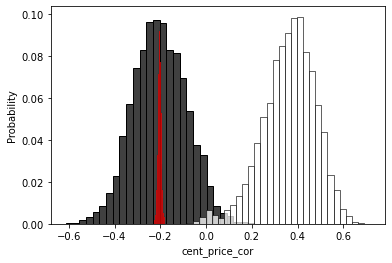

In [8]:
sns.histplot(data=df, x="cent_price_cor", stat="probability", bins=30, color="black")
sns.histplot(data=df, x="cent_trans_cor", stat="probability", bins=30, color="w")

for i in inputs:
    sns.histplot(data=df_out, x=i, stat="probability",bins=30, color="r")